Calculate the solvent accessible surface area (SASA)
---

To quantify the influence of NP topology in the PLGA self-assembling, we carry out this post-processing analysis per crystalline plane during the simulations.

## Libraries

In [95]:
import os
import glob
import mdtraj 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Set figure style

In [96]:
plt.style.use('figure_style.mplstyle')

## Time evolution of SASA corresponding to the crystalline planes {1 0 0} and {1 1 1} <a name="S1"></a> 

We perform the following steps for each configuration:

1. We create in each folder (`60`, `30`, `20`, `10`) a subfolder called SASA;
2. In the subfolder we run: `gmx sasa -f ../MD/md_run.xtc -s ../MD/md_run.tpr -n ../MD/index.ndx -o sasa.xvg -oa atomsasa.xvg -b {f_start} -e {f_end}`; 
3. We select for the SASA calculation the whole system, i.e. AuNP and PLGAs;
4. Important for our analysis will be the output `atomsasa.xvg` that represents the average area per atom.

> **NOTE 1**: We run a `for` cycle to change the variables `f_start` and `f_end` and conduct the same analysis for each ns.

> **NOTE 2**: We simulated with the same MD protocol a configuration in which there is only the AuNP without PLGAs and then calculated its SASA so as to know the reference surface area.

### Loading files <a name="S1.1"></a> 

In [128]:
dir_sim = '../simulations/1-PLGA_self-assembly'
sasa_path_all = glob.glob(os.path.join(dir_sim,'*','SASA','*','atomsasa.xvg'))
gro_path_all =glob.glob(os.path.join(dir_sim, '*','MD', 'md_run.gro'))
sim_folder_all =  glob.glob(os.path.join(dir_sim,'*'))

In [43]:
# We need the .gro file only to distinguish the atom type of the AuNP, so we load one .gro file (the AuNP is always the same in all configurations).
gro_data = mdtraj.load(gro_path_all[2])

### Function to read files <a name="S1.2"></a> 

In [103]:
def read_xvg(filepath):
    if not isinstance(filepath, str):
        raise ValueError('I need a string!')
    output = []
    with open(filepath, 'r') as file_:
        for line in file_:
            line_splited = line.split()
            first_char = line[0]
            if first_char == '#' or first_char == '@':
                continue
            output.append([float(i) for i in line_splited])
    return np.array(output)

### Save the data <a name="S1.3"></a> 

In [131]:
nPLGA = np.zeros(len(sim_folder_all))
for i, sim_folder_all_ in enumerate(sim_folder_all):
    folder_nPLGA = sim_folder_all_.split(os.sep)[-1]
    try:
        nPLGA[i] = int(folder_nPLGA[0:2])
    except ValueError:
        nPLGA[i] = 0
print(nPLGA)

[20. 30.  0. 60. 10.]


In [132]:
N_steps = 100                                                        # 100 ns 
columns = ['time']
for i in [0, 10, 20, 30, 60]:
    columns += [f'{i}_AU1', f'{i}_AU2', f'{i}_AU3']
N_variables = len(columns)
postp_df = pd.DataFrame(np.ones((N_steps, N_variables))*np.nan,
                   columns=columns)
postp_df.head()

,time,0_AU1,0_AU2,0_AU3,10_AU1,10_AU2,10_AU3,20_AU1,20_AU2,20_AU3,30_AU1,30_AU2,30_AU3,60_AU1,60_AU2,60_AU3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
indx_sort = nPLGA.argsort()
nPLGA = nPLGA[indx_sort]
sim_folder_all = np.array(sim_folder_all)[indx_sort]
sim_folder_all

array(['../simulations/1-PLGA_self-assembly/0',
       '../simulations/1-PLGA_self-assembly/10',
       '../simulations/1-PLGA_self-assembly/20',
       '../simulations/1-PLGA_self-assembly/30',
       '../simulations/1-PLGA_self-assembly/60'], dtype='<U38')

In [111]:
atom_type = np.array([str(a_name).split('-')[1] for a_name in list(gro_data.topology.atoms)])
ind_au1 = np.where(atom_type == 'AU1')[0]
ind_au2 = np.where(atom_type == 'AU2')[0]
ind_au3 = np.where(atom_type == 'AU3')[0]

In [142]:
for sim_folder, nplga in zip(sim_folder_all, nPLGA.astype('int32')) : 
    for  i in range(int(len(sasa_path_all)/len(sim_folder_all))):  
        sasa_path = glob.glob(os.path.join(sim_folder,'SASA', f'sasa{i}','atomsasa.xvg'))[0]   
        sasa_all = read_xvg(sasa_path)
        sasa_au1 = sasa_all[ind_au1, 1].sum()
        sasa_au2 = sasa_all[ind_au2, 1].sum()
        sasa_au3 = sasa_all[ind_au3, 1].sum()
        postp_df.loc[i, 'time'] = i*1000+500
        postp_df.loc[i, f'{nplga}_AU1'] = sasa_au1
        postp_df.loc[i, f'{nplga}_AU2'] = sasa_au2
        postp_df.loc[i, f'{nplga}_AU3'] = sasa_au3

In [136]:
postp_df

,time,0_AU1,0_AU2,0_AU3,10_AU1,10_AU2,10_AU3,20_AU1,20_AU2,20_AU3,30_AU1,30_AU2,30_AU3,60_AU1,60_AU2,60_AU3
0,500.0,11.775,39.914,34.462,11.871,39.733,34.356,11.873,39.740,34.327,11.575,38.854,33.337,11.815,39.717,34.124
1,1500.0,11.684,39.481,34.027,11.896,39.714,34.355,11.880,39.725,34.357,11.723,37.673,33.155,11.871,37.803,33.469
2,2500.0,11.586,38.428,33.561,11.880,39.744,34.289,11.855,39.749,34.353,11.765,37.705,33.121,11.827,35.803,33.378
3,3500.0,11.665,38.460,33.790,11.879,39.710,34.331,11.848,39.745,34.385,11.752,37.036,33.213,11.529,33.984,32.002
4,4500.0,11.612,39.215,34.127,11.859,39.804,34.327,11.898,39.150,34.063,11.826,36.449,32.871,11.440,32.795,31.271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95500.0,10.870,37.656,33.053,9.244,30.406,29.889,7.929,20.586,25.306,7.158,16.591,21.432,6.567,7.399,15.105
96,96500.0,10.301,36.894,32.578,9.271,30.354,29.676,8.005,20.566,25.291,6.953,16.607,21.219,6.581,7.404,15.323
97,97500.0,10.113,37.599,32.416,9.306,30.315,29.694,7.939,20.114,25.672,6.936,16.448,21.421,6.644,7.577,15.254
98,98500.0,9.945,37.989,32.498,9.289,30.424,29.694,7.762,20.167,25.910,6.933,16.156,21.632,6.587,7.510,15.348


### Plot the results <a name="S1.4"></a> 

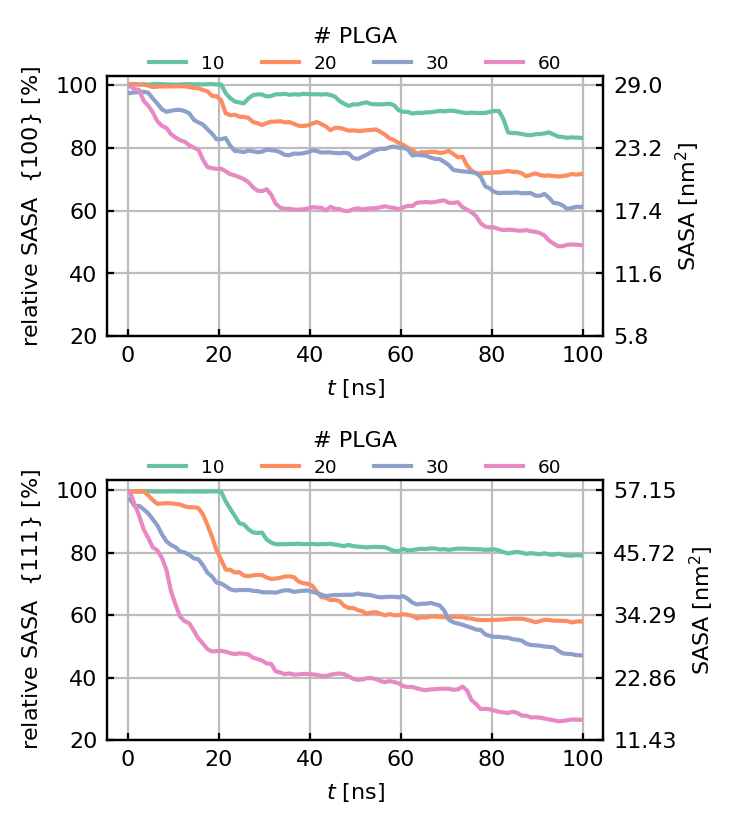

In [141]:
fig1 = plt.figure(1, figsize=(3.2,4.4), dpi=200)
grid = fig1.add_gridspec(2, 1, hspace=0.55)
ax1 = fig1.add_subplot(grid[0])
ax2 = fig1.add_subplot(grid[1])

cmap = plt.get_cmap('Set2')

for j, nplga in enumerate(nPLGA[1:].astype('int32')):
    y_both = postp_df[f'{nplga}_AU3']
    tot_both = postp_df[f'0_AU3'][0]  
    y = ((postp_df[f'{nplga}_AU1'] + (y_both/2))/ (postp_df[f'0_AU1'][0] + (tot_both/2))) *100 
    ax1.plot((postp_df['time'])/1000, y, color = cmap(j) , label=f'{nplga}')
    y1 = ((postp_df[f'{nplga}_AU2'] + (y_both/2))/ (postp_df[f'0_AU2'][0] + (tot_both/2))) *100 
    ax2.plot((postp_df['time'])/1000, y1, color = cmap(j), label=f'{nplga}')

ax1.legend(loc = 'upper center', bbox_to_anchor = [0.5,1.25] , ncol = 4, title = '# PLGA', edgecolor = 'None', facecolor = 'None' )    
ax2.legend(loc = 'upper center', bbox_to_anchor = [0.5,1.25] , ncol = 4, title = '# PLGA', edgecolor = 'None', facecolor = 'None' )

ax1.set_xlabel('$t$ [ns]')   
ax2.set_xlabel('$t$ [ns]')

ax1.set_ylabel('relative SASA $\ {\{100\}}$ [%]')   
ax2.set_ylabel('relative SASA $\ {\{111\}}$ [%]')

ax1_1 = ax1.twinx()   
ax2_1 = ax2.twinx()

ytick1 = ax1.set_yticks((20, 40, 60, 80, 100)) 
ytick2 =  ax2.set_yticks((20, 40, 60, 80, 100))
ax1_ticks = ax1.get_yticks()   
ax2_ticks = ax2.get_yticks()

ax1_1.set_yticks(np.array(ax1_ticks)*(postp_df.loc[0,'0_AU1'] + (tot_both/2))/100)   
ax2_1.set_yticks(np.array(ax2_ticks)*(postp_df.loc[0,'0_AU2'] + (tot_both/2))/100)

ax1_lim = ax1.get_ylim()   
ax2_lim = ax2.get_ylim()

ax1_1.set_ylim(np.array(ax1_lim)*(postp_df.loc[0,'0_AU1'] + (tot_both/2))/100)   
ax2_1.set_ylim(np.array(ax2_lim)*(postp_df.loc[0,'0_AU2'] + (tot_both/2))/100)

ax1_1.set_ylabel('SASA [nm$^{2}$]')   
ax2_1.set_ylabel('SASA [nm$^{2}$]')

ax1_1.grid(False)   
ax2_1.grid(False)

## Histogram of the total AuNP SASA at the last time step simulated <a name="S2"></a> 

In this case for each configuration we consider the output `atomsasa.xvg` of the last ns of simulation. For greater precision we do not take the value exactly to 100 ns but we consider an average on the last 20 ns.

We calculate the average of SASA over the last 20 ns.

In [143]:
rows = 1
columns = []
for i in [0, 10, 20, 30, 60]:
    columns += [f'{i}_AU1', f'{i}_AU2', f'{i}_AU3']
N_variables = len(columns)
sasa_mean = pd.DataFrame(np.ones((rows, N_variables))*np.nan,
                   columns=columns)
sasa_mean.head()

,0_AU1,0_AU2,0_AU3,10_AU1,10_AU2,10_AU3,20_AU1,20_AU2,20_AU3,30_AU1,30_AU2,30_AU3,60_AU1,60_AU2,60_AU3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
for i in [1,2,3]:
    sasa_mean.loc[0, f'0_AU{i}'] = postp_df[f'0_AU{i}'][80:].mean()
    sasa_mean.loc[0, f'10_AU{i}'] = postp_df[f'10_AU{i}'][80:].mean()
    sasa_mean.loc[0, f'20_AU{i}'] = postp_df[f'20_AU{i}'][80:].mean()   
    sasa_mean.loc[0, f'30_AU{i}'] = postp_df[f'30_AU{i}'][80:].mean()  
    sasa_mean.loc[0, f'60_AU{i}'] = postp_df[f'60_AU{i}'][80:].mean()  

In [145]:
sasa_mean

,0_AU1,0_AU2,0_AU3,10_AU1,10_AU2,10_AU3,20_AU1,20_AU2,20_AU3,30_AU1,30_AU2,30_AU3,60_AU1,60_AU2,60_AU3
0,11.5105,38.50585,33.7737,9.53405,30.4308,30.2587,7.9554,20.53225,25.6223,7.4867,17.65905,22.1421,7.15065,7.82495,15.76215


We calculate the standard deviation function of SASA over the last 20 ns.

In [146]:
rows = 1
columns = []
for i in [0, 10, 20, 30, 60]:
    columns += [f'{i}_AU1', f'{i}_AU2', f'{i}_AU3']
N_variables = len(columns)
sasa_std = pd.DataFrame(np.ones((rows, N_variables))*np.nan,
                   columns=columns)
sasa_std.head()

,0_AU1,0_AU2,0_AU3,10_AU1,10_AU2,10_AU3,20_AU1,20_AU2,20_AU3,30_AU1,30_AU2,30_AU3,60_AU1,60_AU2,60_AU3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
for i in [1,2,3]:
    sasa_std.loc[0, f'0_AU{i}'] = postp_df[f'0_AU{i}'][80:].std()
    sasa_std.loc[0, f'10_AU{i}'] = postp_df[f'10_AU{i}'][80:].std()
    sasa_std.loc[0, f'20_AU{i}'] = postp_df[f'20_AU{i}'][80:].std()   
    sasa_std.loc[0, f'30_AU{i}'] = postp_df[f'30_AU{i}'][80:].std()  
    sasa_std.loc[0, f'60_AU{i}'] = postp_df[f'60_AU{i}'][80:].std()  

In [148]:
sasa_std

,0_AU1,0_AU2,0_AU3,10_AU1,10_AU2,10_AU3,20_AU1,20_AU2,20_AU3,30_AU1,30_AU2,30_AU3,60_AU1,60_AU2,60_AU3
0,0.781836,0.820589,0.706672,0.399206,0.189237,0.752818,0.166062,0.234753,0.197635,0.347629,0.979703,0.480653,0.432865,0.431613,0.467746


Imports SASA data of the AuNP in the absence of PLGAs related to the last simulation ns (reference surface area).

In [204]:
sasa_data = glob.glob(os.path.join(dir_sim,'0','SASA','atomsasa.xvg'))
print(f'xvg: {sasa_data}')
sasa_tot0 = read_xvg(sasa_data[0])
y_tot0 = np.sum(sasa_tot0[:,1])

xvg: ['../simulations/1-PLGA_self-assembly/0/SASA/atomsasa.xvg']


### Plot the results <a name="S2.1"></a> 

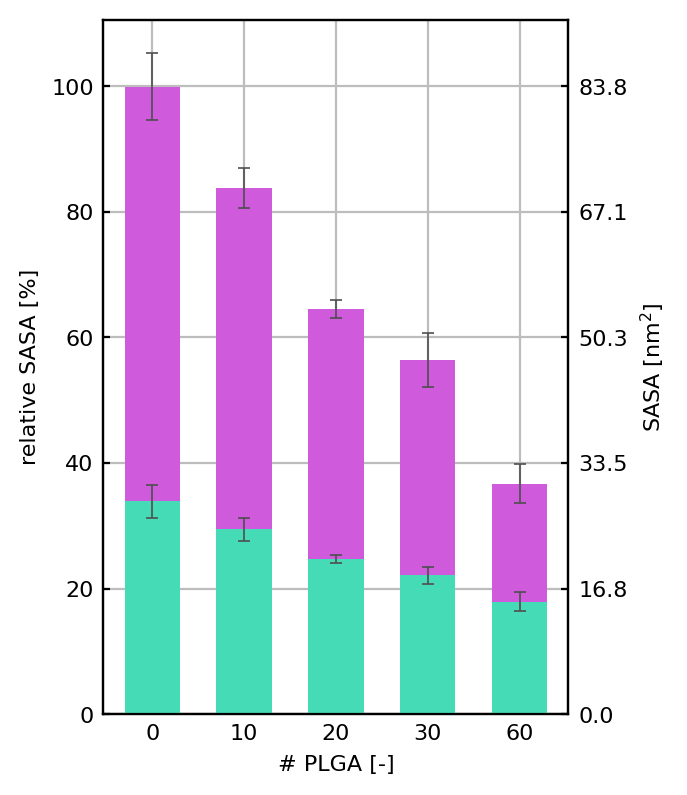

In [205]:
fig2 = plt.figure(1, figsize=(3,4.6), dpi=200)
ax = fig2.add_subplot(111)
ax_twin = ax.twinx()
error_bar_style = dict(
    ecolor='#4f4f4f', 
    capsize=2,
    zorder=100, 
    capthick=0.6, 
    elinewidth=0.6
)
z_conf = 1.96 # i.e Confidence Interval 95%

sys_name = ['0','10','20','30','60']
for i, sasa in enumerate(sim_folder_all):
    y100 = sasa_mean[f'{sys_name[i]}_AU1'] + (sasa_mean[f'{sys_name[i]}_AU3'])/2
    y_100std = sasa_std[f'{sys_name[i]}_AU1'] + (sasa_std[f'{sys_name[i]}_AU3'])/2
    err100 = (y_100std/y_tot0)*100*z_conf
    
    y111 = sasa_mean[f'{sys_name[i]}_AU2'] + (sasa_mean[f'{sys_name[i]}_AU3'])/2
    y_111std = sasa_std[f'{sys_name[i]}_AU2'] + (sasa_std[f'{sys_name[i]}_AU3'])/2
    err111=(y_111std/y_tot0)*100*z_conf
    
    h100 = (y100/y_tot0)*100 
    bar = ax.bar(i, h100, width=0.6, zorder=11, color = '#44DBB6')
    ax.errorbar(i, h100, yerr=err100, **error_bar_style)

    h111 = (y111/y_tot0)*100
    bar = ax.bar(i, h100+h111, width=0.6, zorder=10, color = '#CF5ADB')
    ax.errorbar(i, h100+h111, yerr=err100+err111, **error_bar_style)

x_ticks = np.arange(5)
y_ticks = ax.get_yticks()
y_lim = ax.get_ylim()
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{st}' for st in ['0', '10','20','30','60']])
ax.set_ylabel("relative SASA [%]")
ax.set_xlabel("# PLGA [-]")
ax_twin.set_yticks(y_ticks/100*np.sum(sasa_tot0[:,1]))
ax_twin.set_ylim(np.array(y_lim)/100*np.sum(sasa_tot0[:,1]))
ax_twin.set_ylabel('SASA [nm$^2$]')
ax_twin.grid(False)